In [133]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [134]:
# parameters
# dimensions of the problem 
dim = 2
# number of neurons of 1st layer
m = 200
# number of neurons of subsequent layers
hidden_u = []
# number of data points
n = 90
# bounds of the x1 and x2
bounds = [1.6, 4]
# number of points for the test dataset
test_n =30
batch_n = 90
buff = 1024
epochs = 400
tol = 1e-5
# a = tf.Variable(tf.zeros((m,)), trainable=True)

# vector field 2d from paper
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] + (1-x[:,0]**2)*x[:,1]]
    return y

# # vector field 3d from paper
# def vf(x):
#     y = [x[:,0] * (x[:,0]**2 + x[:,1]**2 -1) - x[:,1] * (x[:,2]**2 + 1),
#          x[:,1] * (x[:,0]**2 + x[:,1]**2 -1) - x[:,0] * (x[:,2]**2 + 1),
#          10 * x[:,2] * (x[:,2]**2 - 1)]
#     return y 



In [135]:
class Create_Data():
    
    def __init__(self, vf, dim):
        super(Create_Data, self).__init__()
        self.vf = vf
        self.dim = dim
    
    def create_raw_data(self, train_n, bounds, test_n):
        # n is the number of points, bounds is a list of bounds for the d-dimensional data
        if self.dim == 2:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n)]).T
        elif self.dim == 3:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n),  np.random.uniform(-bounds[2],bounds[2],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n),  np.random.uniform(-bounds[2],bounds[2],test_n)]).T
        else:
            return('wrong dimensions')
        vfdata = self.vf(omega_domain)
        tdata = tf.convert_to_tensor(omega_domain, dtype=tf.float32)
        tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))
        test_vfdata = self.vf(test_omega_domain)
        test_tdata = tf.convert_to_tensor(test_omega_domain, dtype=tf.float32)
        test_tvf     = kb.transpose(tf.convert_to_tensor(test_vfdata, dtype=tf.float32))

        train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
        test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_tdata, test_tvf))

        return train_dataset_raw, test_dataset_raw
    
    def shuffle_and_batch_dataset(self, dataset, batch_size, shuffle_buffer=None):
        if shuffle_buffer:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer)
            
        dataset = dataset.batch(batch_size)
        return(dataset)
        

In [136]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=input_shape, name = 'state')
    # h = inputs
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=True)(inputs)
    h = np.sqrt(2) * h
    for units in hidden_units:
        # h = tf.keras.layers.Dense(units, activation='selu', 
        #                           kernel_regularizer=tf.keras.regularizers.l2(l2_reg_coeff))(h)
        h = tf.keras.layers.Dense(units, activation='linear')(h)
        # h = tf.keras.layers.BatchNormalization()(h)
        # h = tf.keras.layers.Dropout(dropout_rate)(h)
    # outputs = tf.keras.layers.Dense(10, activation=None)(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    if m >= 1000:
        # only divide by m if the number of neurons exceeds a certain threshold
        print('ep!!!')
        outputs = outputs / m
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 200)               600       
                                                                 
 tf.math.multiply_12 (TFOpLa  (None, 200)              0         
 mbda)                                                           
                                                                 
 output_layer (Dense)        (None, 1)                 200       
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


In [137]:
# Custom tensorflow functions for loss and training

# define the part of the loss function implementing the PDE
@tf.function
def grad_loss_eq(gradx, x_batch_train, vf_batch_train):
    # LHS of eq 6.4
    # divided by D
    # g_loss = kb.sum(kb.square(kb.sum(gradx*vf_batch_train,axis=1) + kb.sum(kb.square(x_batch_train),axis=1))) / len(x_batch_train)
    g_loss = tf.math.reduce_sum(tf.math.square(tf.math.reduce_sum(gradx*vf_batch_train,axis=1) + tf.math.reduce_sum(tf.math.square(x_batch_train), axis=1))) / len(x_batch_train)

    # g_loss = kb.sum(kb.square(kb.sum(gradx*vf_batch_train,axis=1) + kb.sum(kb.square(x_batch_train),axis=1))) 

    return g_loss

opt = tf.keras.optimizers.Adam(learning_rate=0.05)
gradweight = 1
# this function performs the optimization for a train step
@tf.function
def train_step(x_batch_train, vf_batch_train):

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:

    # evaluate model
    # try trainable = False
    logits = model(x_batch_train)

    # start gradient recording for derivative w.r.t. x
    with tf.GradientTape() as tapex:

      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      # not sure if training should be false here.
      logits2 = model(x_batch_train)

      # evaluate x-derivative
      gradx = tapex.gradient(logits2, x_batch_train)

      # evaluate PDE part of loss function
      gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
      # this is the w in the loss equation   
      loss_value =  gradweight * gloss

    # evaluate derivative w.r.t. model parameters
    #changed this
  grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent optimizer
    #changed this
  opt.apply_gradients(zip(grads, model.trainable_weights))

  return(loss_value,gloss)


@tf.function
def test_step(x_test, vf_test):

  y_pred = model(x_test, training=False)

  with tf.GradientTape() as tapex:

    tapex.watch(x_test)
    # not sure if training should be false here.
    logits2 = model(x_test, training =False)

    # evaluate x-derivative
    #changed this
  gradx = tapex.gradient(logits2, x_test)

  loss = grad_loss_eq(gradx, x_test, vf_test)
  return gradweight * loss

In [138]:
def custom_training_loop(epochs, tol, train_dataset, validation_dataest):

    all_loss_values = []
    all_test_loss_values = []

    start = time.perf_counter()

    # loop through the epochs
    for epoch in range(epochs):

        # initialize error variables, mlv=maximum (L_infty), slv = L_1
        mlv = 0.0
        slv = 0.0
        
        # Iterate over the batches of the dataset
        for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

            # call optimization routine
            [loss_value,gloss] = train_step(x_batch_train, vf_batch_train)
            all_loss_values.append(loss_value.numpy())


            # update errors
            # mlv = kb.max([mlv,loss_value],0)
            mlv = tf.math.reduce_max([mlv,loss_value],0)
            # mlv = tf.math.maximum([mlv,loss_value],0)

            slv = slv + loss_value

            # # print log information every 100 steps
            # if step % 100 == 0:
            #   print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv), end = '\r')

        for step, (x_test, vf_test) in enumerate(validation_dataest):
            test_loss = test_step(x_test, vf_test)
            all_test_loss_values.append(test_loss)

        # print log information at end of epoch    
        # print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv))
        if epoch % 100 == 0:
            print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))


        # terminate if L_infty error is sufficiently small
        if mlv < tol:
            print('op')
            break

    print("End of training, time: {:.4f}".format(time.perf_counter() - start))
    return all_loss_values, all_test_loss_values

In [139]:
my_data = Create_Data(vf, dim)
tr, te = my_data.create_raw_data(n, bounds, test_n)
tr = my_data.shuffle_and_batch_dataset(tr, batch_n, buff)
te = my_data.shuffle_and_batch_dataset(te, batch_n)

In [140]:
all_loss_values, all_test_loss_values = custom_training_loop(epochs, tol, tr, te)

epoch  0, loss  80.221207
epoch 100, loss   2.270897
epoch 200, loss   1.335754
epoch 300, loss   1.089589
End of training, time: 3.2680


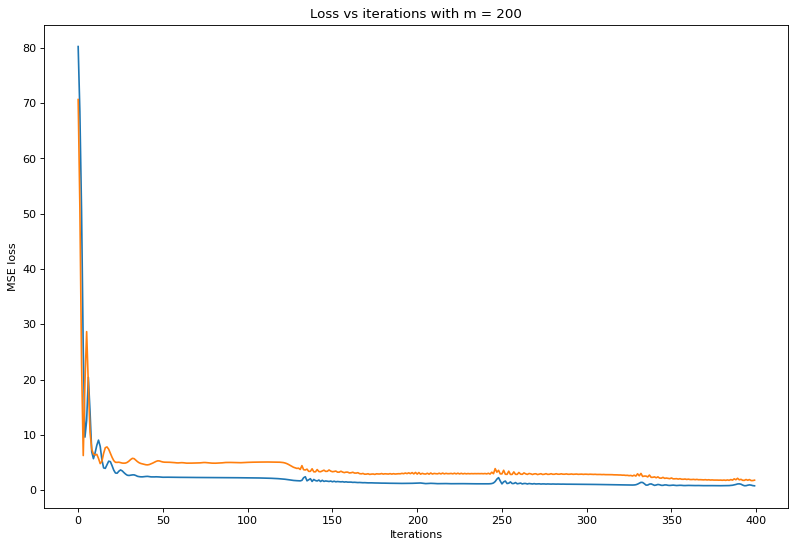

In [141]:
plt.plot(all_loss_values)
plt.plot(all_test_loss_values)
plt.title("Loss vs iterations with m = {}".format(m))
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
# plt.xscale('log')
plt.show()

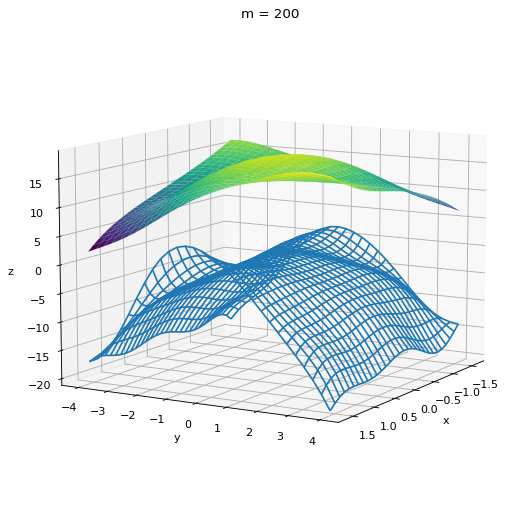

In [142]:
###### plot result ######

# define resolution
numpoints = 30

# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# evaluate model (= Lyapunov function values V)
Ep = model.predict(DT)

# convert point vector to tensor for evaluating x-derivative
tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

# evaluate gradients DV of Lyapunov function
with tf.GradientTape() as tape:
    tape.watch(tDT)
    ypm = model(tDT)
    grads = tape.gradient(ypm, tDT)

# compute orbital derivative DVf
Ee = tf.math.reduce_sum(grads*tf.transpose(tf.convert_to_tensor(vf(DT), dtype=tf.float32)), axis=1)

# copy V and DVf values into plottable format
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        Ze[i,j] = Ee[c]
        Zp[i,j] = Ep[c]
        c = c+1;


# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, numpoints, numpoints))

# define figure
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_title('m = {}'.format(m))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# plot values V
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# plot orbital derivative DVf
ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

# change angles to see graph more clearly
ax.view_init(-140, 60)
ax.view_init(10, 30)


plt.show()

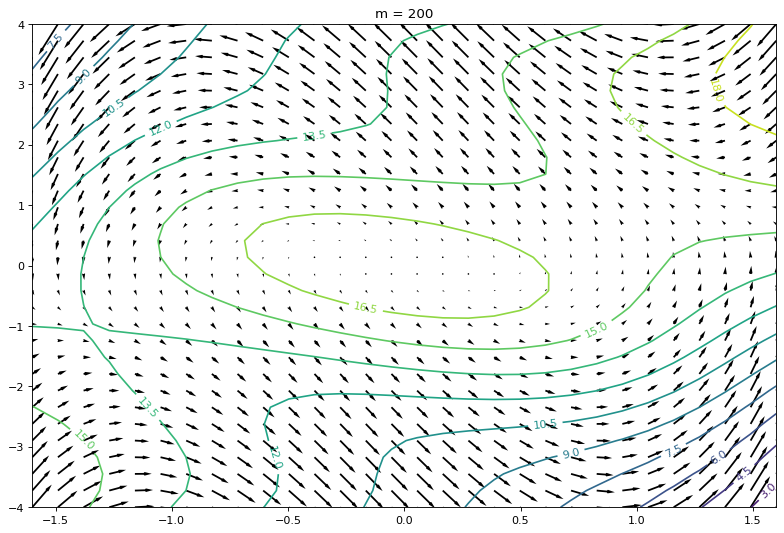

In [143]:
cp = plt.contour(x,y,Zp, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.title('m = {}'.format(m))
plt.show()

In [145]:
print(x.shape)

(30,)
